<a href="https://colab.research.google.com/github/AbhinandanRoy7/Project/blob/main/PneumoniaClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
import os,shutil
import random
import numpy as np
import pandas as pd
import cv2
import skimage
import skimage.segmentation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [ ]:
import os
import cv2
import numpy as np

labels = ['PNEUMONIA', 'NORMAL']
img_size = 128

def get_data(data_dir):
    data = []

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)

        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            try:
                # Read image in grayscale
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                # Ensure the image was loaded correctly
                if img_arr is None:
                    print(f"Warning: Failed to load image {img_path}")
                    continue  # Skip this image

                # Resize image
                resized_arr = cv2.resize(img_arr, (img_size, img_size))

                # Append processed data
                data.append([resized_arr, class_num])

            except Exception as e:
                print(f"Error processing image {img_path}: {e}")

    return np.array(data, dtype=object)  # Ensure consistent array type

In [ ]:
train = get_data("/content/chest_xray/chest_xray/train")
test = get_data("/content/chest_xray/chest_xray/test")
val = get_data("/content/chest_xray/chest_xray/val")
print(f"Loaded {len(train)} train images successfully.\nLoaded {len(test)} test images successfully.\nLoaded {len(val)} val images successfully.")

Loaded 5216 train images successfully.
Loaded 624 test images successfully.
Loaded 16 val images successfully.


In [ ]:
pneu=os.listdir("/content/chest_xray/train/PNEUMONIA")
pneu_dir="/content/chest_xray/train/PNEUMONIA"

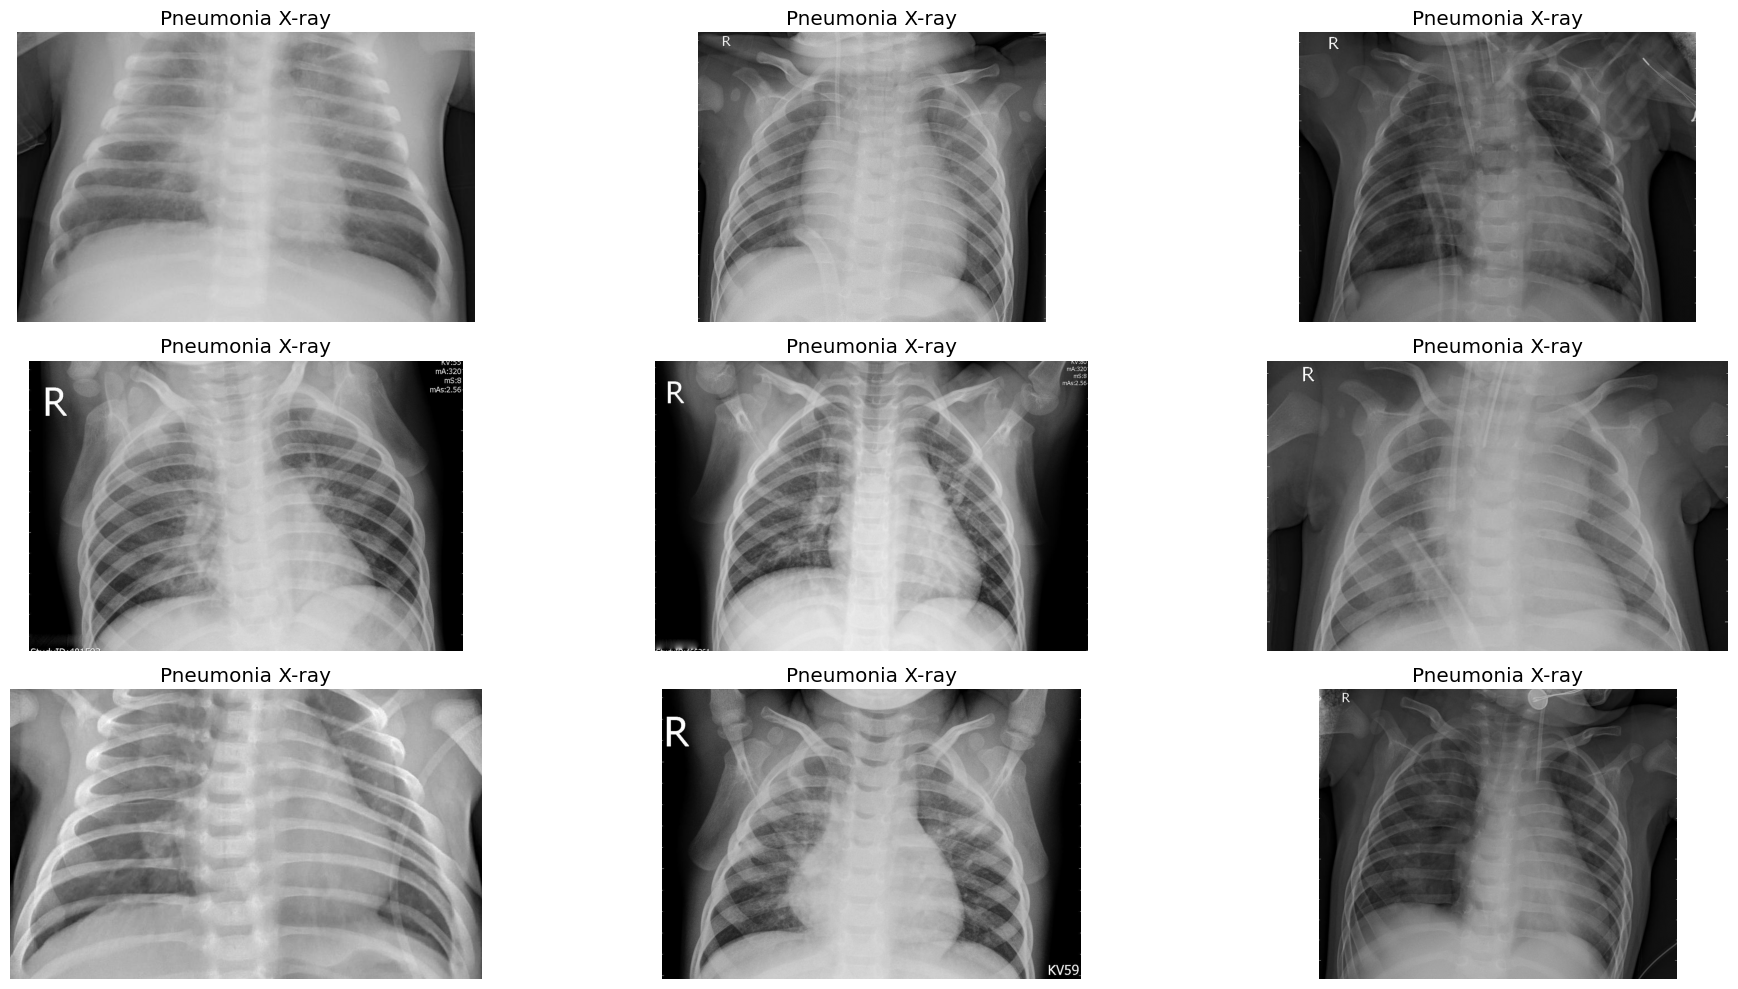

In [ ]:
plt.figure(figsize=(20,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  img=plt.imread(os.path.join(pneu_dir,pneu[i]))
  plt.imshow(img,cmap='gray')
  plt.axis("off")
  plt.title("Pneumonia X-ray")
plt.tight_layout()

In [ ]:
nor=os.listdir("/content/chest_xray/train/NORMAL")
nor_dir="/content/chest_xray/train/NORMAL"

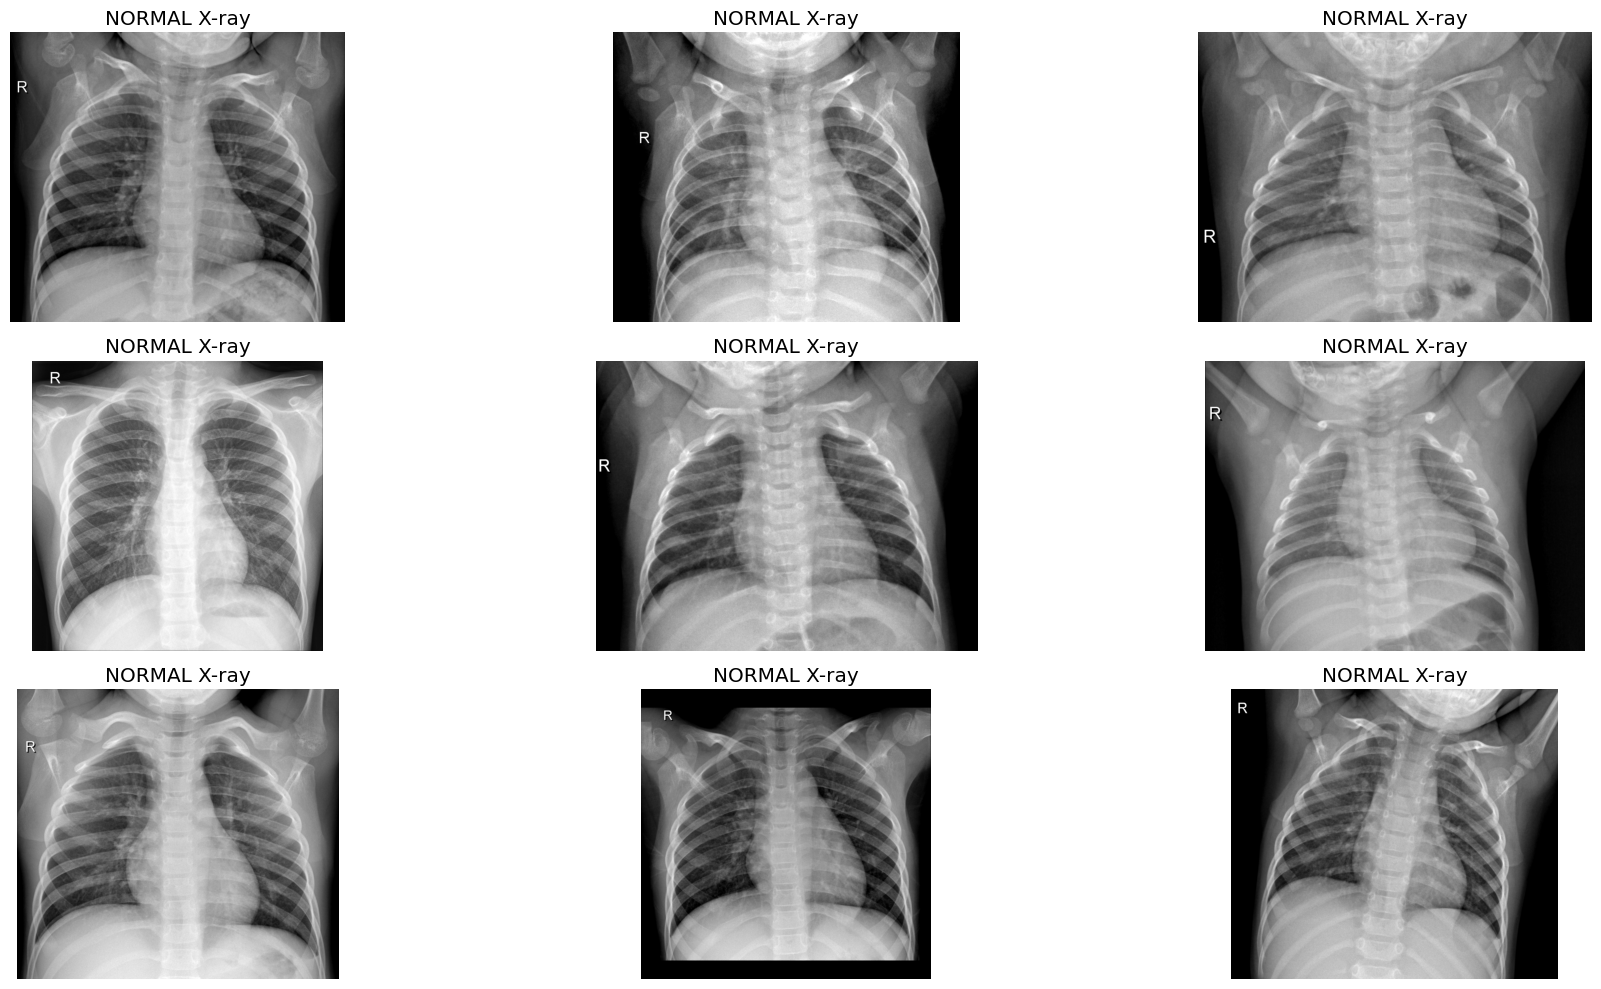

In [ ]:
plt.figure(figsize=(20,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  img=plt.imread(os.path.join(nor_dir,nor[i]))
  plt.imshow(img,cmap='gray')
  plt.axis("off")
  plt.title("NORMAL X-ray")
plt.tight_layout()

<Axes: xlabel='count'>

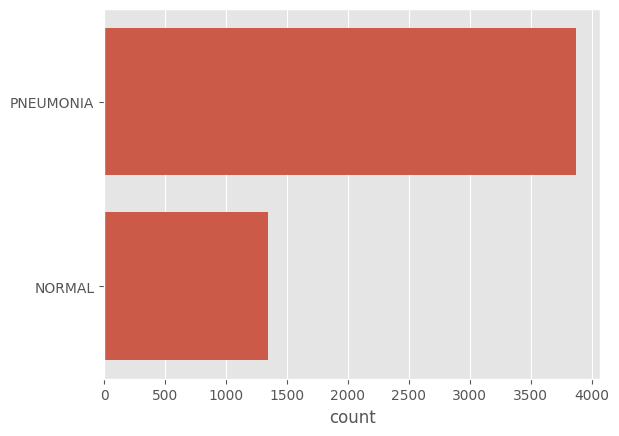

In [ ]:
l=[]
for i in train:
  if(i[1]==0):
    l.append("PNEUMONIA")
  else:
    l.append("NORMAL")
sns.countplot(l)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D,Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1. / 255,
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=40,
                  shear_range=0.2,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode="nearest")
valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory("chest_xray/chest_xray/train",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')
val_generator = valid_datagen.flow_from_directory("chest_xray/chest_xray/val",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
class_labels=train_generator.class_indices

In [ ]:
class_labels

{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
class_name={value:key for (key,value) in class_labels.items()}

In [ ]:
base_model = VGG19(input_shape = (128,128,3),
                     include_top = False,
                     weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
flat = Flatten()(x)


class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.inputs, output)
model_01.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 43,065,218 (164.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
filepath = "model.h5"
es = EarlyStopping(monitor="val_loss", verbose=1, mode="min", patience=4)
cp=ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, save_weights_only=False,mode="auto", save_freq="epoch")
lrr = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.5, min_lr=0.0001)

sgd = SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

model_01.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
history_01 = model_01.fit(train_generator,
            steps_per_epoch=50,
            epochs=10,
            callbacks=[es, cp, lrr],
            validation_data=val_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.6916 - loss: 0.5926

50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 569ms/step - accuracy: 0.6925 - loss: 0.5918 - val_accuracy: 0.6250 - val_loss: 0.5734 - learning_rate: 1.0000e-04
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.7704 - loss: 0.4757

50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 473ms/step - accuracy: 0.7705 - loss: 0.4756 - val_accuracy: 0.8125 - val_loss: 0.5147 - learning_rate: 1.0000e-04
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.8003 - loss: 0.4245

50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 443ms/step - accuracy: 0.8001 - loss: 0.4248 - val_accuracy: 0.8125 - val_loss: 0.4879 - learning_rate: 1.0000e-04
Epoch 4/10
13/50 ━━━━━━━━━━━━━━━━━━━━ 12s 330ms/step - accuracy: 0.7879 - loss: 0.4660

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.8008 - loss: 0.4397 - val_accuracy: 0.6250 - val_loss: 0.5544 - learning_rate: 1.0000e-04
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 78s 424ms/step - accuracy: 0.7958 - loss: 0.4181 - val_accuracy: 0.7500 - val_loss: 0.5121 - learning_rate: 1.0000e-04
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 399ms/step - accuracy: 0.8004 - loss: 0.4275 - val_accuracy: 0.7500 - val_loss: 0.5385 - learning_rate: 1.0000e-04
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 417ms/step - accuracy: 0.8212 - loss: 0.3901 - val_accuracy: 0.7500 - val_loss: 0.5529 - learning_rate: 1.0000e-04
Epoch 7: early stopping


In [ ]:
if not os.path.isdir('model_weights/'):
  os.mkdir("model_weights/")
model_01.save(filepath="model_weights/vgg19_model_01.h5",overwrite=True)

In [ ]:
test_generator = train_datagen.flow_from_directory("chest_xray/chest_xray/test",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')

Found 624 images belonging to 2 classes.


In [ ]:
model_01.load_weights("model_weights/vgg19_model_01.h5")
val_eval=model_01.evaluate(val_generator)
test_eval=model_01.evaluate(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.7500 - loss: 0.5529
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 310ms/step - accuracy: 0.6831 - loss: 0.5917


In [ ]:
print(f"Validation Loss: {val_eval[0]}")
print(f"Validation Accuracy: {val_eval[1]}")
print(f"Test Loss: {test_eval[0]}")
print(f"Test Accuracy: {test_eval[1]}")

Validation Loss: 0.5529499053955078
Validation Accuracy: 0.75
Test Loss: 0.6146619319915771
Test Accuracy: 0.6842948794364929


In [ ]:
#training and unfreezing
base_model = VGG19(include_top=False, input_shape=(128,128,3))
base_model_layer_names = [layer.name for layer in base_model.layers]

x = base_model.output
flat = Flatten()(x)


class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights("model_weights/vgg19_model_01.h5")

set_trainable = False
for layer in base_model.layers:
    if layer.name in [ 'block5_conv3','block5_conv4']:
        set_trainable=True
    if set_trainable:
        set_trainable=True
    else:
        set_trainable=False
print(model_02.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 63,089,602 (240.67 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
base_model_layer_names

['input_layer_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [ ]:
sgd = SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

model_02.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

In [ ]:
history_02 = model_02.fit(train_generator,
            steps_per_epoch=50,
            epochs=10,
            callbacks=[es, cp, lrr],
            validation_data=val_generator)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_27']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.8393 - loss: 0.3517

50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 608ms/step - accuracy: 0.8395 - loss: 0.3513 - val_accuracy: 0.8125 - val_loss: 0.4067 - learning_rate: 1.0000e-04
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 412ms/step - accuracy: 0.8844 - loss: 0.2738 - val_accuracy: 0.6875 - val_loss: 0.7291 - learning_rate: 1.0000e-04
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.8902 - loss: 0.2693

50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 515ms/step - accuracy: 0.8902 - loss: 0.2692 - val_accuracy: 0.8125 - val_loss: 0.3265 - learning_rate: 1.0000e-04
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.9046 - loss: 0.2296 - val_accuracy: 0.7500 - val_loss: 0.4687 - learning_rate: 1.0000e-04
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 449ms/step - accuracy: 0.9035 - loss: 0.2211 - val_accuracy: 0.7500 - val_loss: 0.5458 - learning_rate: 1.0000e-04
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - accuracy: 0.9377 - loss: 0.1778 - val_accuracy: 0.7500 - val_loss: 0.4950 - learning_rate: 1.0000e-04
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 428ms/step - accuracy: 0.9227 - loss: 0.1848 - val_accuracy: 0.7500 - val_loss: 0.6569 - learning_rate: 1.0000e-04
Epoch 7: early stopping


In [ ]:
if not os.path.isdir('model_weights/'):
  os.mkdir("model_weights/")
model_02.save(filepath="model_weights/vgg19_model_02.h5",overwrite=True)

In [ ]:
model_02.load_weights("model_weights/vgg19_model_02.h5")
val_eval=model_02.evaluate(val_generator)
test_eval=model_02.evaluate(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.7500 - loss: 0.5529
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 326ms/step - accuracy: 0.6774 - loss: 0.6128


In [ ]:
print(f"Validation Loss: {val_eval[0]}")
print(f"Validation Accuracy: {val_eval[1]}")
print(f"Test Loss: {test_eval[0]}")
print(f"Test Accuracy: {test_eval[1]}")

Validation Loss: 0.5529499053955078
Validation Accuracy: 0.75
Test Loss: 0.6019327640533447
Test Accuracy: 0.6714743375778198


In [ ]:
# unfreezing and finetuning the entire network

In [ ]:
base_model = VGG19(include_top=False, input_shape=(128,128,3))
x = base_model.output
flat = Flatten()(x)


class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_03 = Model(base_model.inputs, output)
model_03.load_weights("model_weights/vgg19_model_01.h5")
print(model_03.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 63,089,602 (240.67 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
sgd = SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

model_03.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
history_03 = model_03.fit(train_generator,
            steps_per_epoch=100,
            epochs=10,
            callbacks=[es, cp, lrr],
            validation_data=val_generator)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_81']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


100/100 ━━━━━━━━━━━━━━━━━━━━ 49s 442ms/step - accuracy: 0.8611 - loss: 0.3190 - val_accuracy: 0.6875 - val_loss: 0.8618 - learning_rate: 1.0000e-04
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 269ms/step - accuracy: 0.9016 - loss: 0.2441 - val_accuracy: 0.7500 - val_loss: 0.4962 - learning_rate: 1.0000e-04
Epoch 3/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.9045 - loss: 0.2170

100/100 ━━━━━━━━━━━━━━━━━━━━ 54s 458ms/step - accuracy: 0.9046 - loss: 0.2169 - val_accuracy: 0.8125 - val_loss: 0.2706 - learning_rate: 1.0000e-04
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - accuracy: 0.9210 - loss: 0.1980 - val_accuracy: 0.7500 - val_loss: 0.4493 - learning_rate: 1.0000e-04
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 432ms/step - accuracy: 0.9217 - loss: 0.1845 - val_accuracy: 0.7500 - val_loss: 0.6180 - learning_rate: 1.0000e-04
Epoch 6/10
 63/100 ━━━━━━━━━━━━━━━━━━━━ 15s 427ms/step - accuracy: 0.9444 - loss: 0.1404

100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 311ms/step - accuracy: 0.9417 - loss: 0.1459 - val_accuracy: 0.8750 - val_loss: 0.2335 - learning_rate: 1.0000e-04
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.9415 - loss: 0.1556

100/100 ━━━━━━━━━━━━━━━━━━━━ 55s 479ms/step - accuracy: 0.9415 - loss: 0.1555 - val_accuracy: 1.0000 - val_loss: 0.1028 - learning_rate: 1.0000e-04
Epoch 8/10
 63/100 ━━━━━━━━━━━━━━━━━━━━ 15s 426ms/step - accuracy: 0.9420 - loss: 0.1483

100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 350ms/step - accuracy: 0.9424 - loss: 0.1476 - val_accuracy: 1.0000 - val_loss: 0.0829 - learning_rate: 1.0000e-04
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 102s 430ms/step - accuracy: 0.9516 - loss: 0.1331 - val_accuracy: 1.0000 - val_loss: 0.1597 - learning_rate: 1.0000e-04
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 270ms/step - accuracy: 0.9507 - loss: 0.1310 - val_accuracy: 1.0000 - val_loss: 0.1444 - learning_rate: 1.0000e-04


In [ ]:
if not os.path.isdir('model_weights/'):
  os.mkdir("model_weights/")
model_02.save(filepath="model_weights/vgg_unfrozen.h5",overwrite=True)

In [ ]:
%cd /content/model_weights

/content/model_weights


In [ ]:
!zip -r models.zip /content/model_weights

  adding: content/model_weights/ (stored 0%)
  adding: content/model_weights/vgg19_model_01.h5 (deflated 13%)
  adding: content/model_weights/vgg19_model_02.h5 (deflated 10%)
  adding: content/model_weights/vgg_unfrozen.h5 (deflated 10%)


In [ ]:
from google.colab import files
files.download('/content/model_weights/models.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>